In [1]:
import pandas as pd
import math
import time
import mcfg #в файле лежат функции pg1,pg2 для подключения к postgresql
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_sql('''
select
	metro,	                  walk_to_metro_flg = 1 walk_to_metro_flg,	address,
	price::float price,       m_sqarea::float m_sqarea,             	floor_flat,	           
    floor_max,	              rooms,	                                latitude,	           
    longitude,                district_name,                        	dist_to_center,
	r_per_meter,              room_square,                          	"Холодильник",
	"Посудомоечная машина",	  "Стиральная машина",                      "Кондиционер",
	"Телевизор",              "Интернет",                               "Мебель на кухне",
    "Мебель в комнатах",      "Оплата ЖКХ",                             "Залог",
    "Предоплата_месяцев",     "Срок аренды",                            "С животными",
    "С детьми",               "Общая площадь",                          "Жилая площадь",
    "Площадь кухни",          "Санузел",                                "Балкон/лоджия",
    "Вид из окон",            "Ремонт",                                 "Год постройки",
    "Количество лифтов",      "Тип перекрытий",                         "Парковка",
    "Отопление",              "Аварийность",                            school_1000m,
    shops_200m,               theatre_1000m,                            fitness_500m,
    cinemas_1500m,            foods_1000m,                              kindergarten_500m,
    libraries_1000m,          parks_2000m,                              post_office_1000m,
    climbing_1000m,           fields_1000m,                             indoor_swimming_pool_1000m,
    malls_2000m,              outdoor_swimming_pool_1000m,              floor_flat = 1 as is_first_floor,
    floor_flat = floor_max is_max_floor
from
	team18.dataset_table''',con=mcfg.pg2())


df.price = (df.price/1000).astype(int) #привожу к тысячам
df['district_name'] = df['district_name'].str.replace(' административный округ','') #для удобства отображения

### Базовый анализ

In [55]:
print('Смотрим типы столбцов и их список')
df.info()

Смотрим типы столбцов и их список
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16057 entries, 0 to 16059
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   metro                        16057 non-null  object 
 1   walk_to_metro_flg            16057 non-null  bool   
 2   address                      16057 non-null  object 
 3   price                        16057 non-null  int32  
 4   m_sqarea                     16057 non-null  float64
 5   floor_flat                   16057 non-null  float64
 6   floor_max                    16057 non-null  float64
 7   rooms                        16057 non-null  int64  
 8   latitude                     16057 non-null  float64
 9   longitude                    16057 non-null  float64
 10  district_name                16057 non-null  object 
 11  dist_to_center               16057 non-null  float64
 12  r_per_meter                  16057 non-n

In [12]:
print(f"""В датасете содержится 
{df.shape[0]} строк
{df.shape[1]} столбцов
{len(df.isna().sum()[df.isna().sum()>0])}/{df.shape[1]} содержат пропуски""")

В датасете содержится 
16060 строк
58 столбцов
28/58 содержат пропуски


In [23]:
print(f"""Рассмотрим детальнее столбцы с пропусками""")
for each in df:
    if df[each].isna().sum() !=0:
        print(f"{each} {' '*(20-len(each))}- {df[each].isna().sum()}/{df.shape[0]}   - {round(df[each].isna().sum()/df.shape[0]*100,2)}% пропущено")

Рассмотрим детальнее столбцы с пропусками
district_name        - 3/16060   - 0.02% пропущено
Холодильник          - 944/16060   - 5.88% пропущено
Посудомоечная машина - 944/16060   - 5.88% пропущено
Стиральная машина    - 944/16060   - 5.88% пропущено
Кондиционер          - 944/16060   - 5.88% пропущено
Телевизор            - 944/16060   - 5.88% пропущено
Интернет             - 944/16060   - 5.88% пропущено
Мебель на кухне      - 944/16060   - 5.88% пропущено
Мебель в комнатах    - 944/16060   - 5.88% пропущено
Оплата ЖКХ           - 944/16060   - 5.88% пропущено
Залог                - 944/16060   - 5.88% пропущено
Предоплата_месяцев   - 944/16060   - 5.88% пропущено
Срок аренды          - 944/16060   - 5.88% пропущено
С животными          - 5842/16060   - 36.38% пропущено
С детьми             - 5842/16060   - 36.38% пропущено
Общая площадь        - 944/16060   - 5.88% пропущено
Жилая площадь        - 4817/16060   - 29.99% пропущено
Площадь кухни        - 3286/16060   - 20.46% пропущен

In [32]:
print('Рассмотрим строки с пустыми адресами')
print('Фактически они не принадлежат Москве и их можно исключить',end='\n\n')
for each in df[df['district_name'].isna()]['address']:
    print(each)
    
df=df[~df['district_name'].isna()]

Рассмотрим строки с пустыми адресами
Фактически они не принадлежат Москве и их можно исключить

Москва, СЗАО, р-н Митино, м. Митино, Северо-Западный ао, улица Парковая, 33
Москва, САО, р-н Молжаниновский, м. Химки, Ленинградское шоссе, 228к5
Москва, СЗАО, р-н Куркино, м. Химки, Куркинское шоссе, 58


In [50]:
print('Столбец metro не содержим пропусков, но фактически tbd - отсутсвует')
print(f"{'metro'} - {df[df['metro']=='tbd']['metro'].count()}/{df.shape[0]}   - {round(df[df['metro']=='tbd']['metro'].count()/df.shape[0]*100,2)}% пропущено")
print('Большая часть находится в Троицом районе')
df[df['metro']=='tbd'].groupby('district_name').agg({'metro':'count'})

Столбец metro не содержим пропусков, но фактически tbd - отсутсвует
metro - 42/16057   - 0.26% пропущено
Большая часть находится в Троицом районе


,metro
district_name,
Восточный,1
Троицкий,41


In [76]:
print('Проверим базовую статистику по числовым столбцам')
print('Видим, что post_office_1000m содержит только 0, выяснено, что в исходных данных неверные координаты')
df.describe()

Проверим базовую статистику по числовым столбцам
Видим, что post_office_1000m содержит только 0, выяснено, что в исходных данных неверные координаты


,price,m_sqarea,floor_flat,floor_max,rooms,latitude,longitude,dist_to_center,r_per_meter,room_square,Холодильник,Посудомоечная машина,Стиральная машина,Кондиционер,Телевизор,Интернет,Мебель на кухне,Мебель в комнатах,Залог,Предоплата_месяцев,Общая площадь,Жилая площадь,Площадь кухни,Год постройки,Аварийность,school_1000m,shops_200m,theatre_1000m,fitness_500m,cinemas_1500m,foods_1000m,kindergarten_500m,libraries_1000m,parks_2000m,post_office_1000m,climbing_1000m,fields_1000m,indoor_swimming_pool_1000m,malls_2000m,outdoor_swimming_pool_1000m
count,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,15113.000000,15113.000000,15113.000000,15113.000000,15113.000000,15113.000000,15113.000000,15113.000000,1.511300e+04,15113.000000,15113.000000,11241.000000,12771.000000,13963.000000,13966.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000,16057.0,16057.000000,16057.000000,16057.000000,16057.000000,16057.000000
mean,108.110731,54.523836,9.134583,17.687052,1.836582,55.730288,37.570356,11.624463,1937.292209,31.171514,0.885000,0.462847,0.942169,0.516046,0.683451,0.773903,0.829418,0.916628,1.051362e+05,0.989148,54.389496,31.226243,10.856284,1995.142233,0.000072,14.502273,4.921965,0.767703,0.871084,1.835773,93.680077,1.911067,0.976833,17.135206,0.0,0.013639,0.050819,0.322601,9.118079,0.015445
std,91.566852,22.754508,8.029398,12.190540,0.748075,0.094437,0.132849,7.013589,928.499972,8.967220,0.319033,0.498634,0.233431,0.499759,0.465145,0.418316,0.376155,0.276453,8.991123e+05,0.224879,22.589261,15.769725,5.156091,25.877052,0.008462,9.140049,5.804655,2.383425,1.940590,2.360032,93.867983,1.985482,0.947665,12.008850,0.0,0.115990,0.223569,0.715901,6.179954,0.123318
min,18.000000,10.000000,1.000000,1.000000,1.000000,55.215698,36.864371,0.000000,250.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,10.000000,1.000000,2.000000,1822.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,39.000000,4.000000,9.000000,1.000000,55.667665,37.488943,6.000000,1323.000000,24.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,5.500000e+04,1.000000,38.900000,20.000000,8.000000,1972.000000,0.000000,7.000000,2.000000,0.000000,0.000000,0.000000,39.000000,0.000000,0.000000,10.000000,0.0,0.000000,0.000000,0.000000,5.000000,0.000000
50%,80.000000,49.000000,7.000000,16.000000,2.000000,55.736493,37.562290,11.000000,1666.000000,30.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.500000e+04,1.000000,49.000000,29.000000,10.000000,2003.000000,0.000000,14.000000,3.000000,0.000000,0.000000,1.000000,64.000000,2.000000,1.000000,15.000000,0.0,0.000000,0.000000,0.000000,9.000000,0.000000
75%,120.000000,64.000000,12.000000,22.000000,2.000000,55.797346,37.655760,15.000000,2272.000000,37.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.100000e+05,1.000000,64.000000,38.000000,12.000000,2020.000000,0.000000,21.000000,6.000000,0.000000,1.000000,2.000000,111.000000,3.000000,1.000000,21.000000,0.0,0.000000,0.000000,0.000000,13.000000,0.000000
max,1700.000000,260.000000,81.000000,101.000000,4.000000,56.008123,37.949931,69.000000,12698.000000,106.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.100000e+08,4.000000,260.000000,200.000000,68.000000,2026.000000,1.000000,74.000000,226.000000,30.000000,26.000000,18.000000,831.000000,33.000000,6.000000,110.000000,0.0,1.000000,2.000000,5.000000,54.000000,1.000000


In [73]:
print('Посмотрим статистику по столбцам типа object')
for each in df:
    if str(df[each].dtype)=='object':
        print(f"{each}{' '*(20-len(each))} - {df[each].nunique(dropna=False)} уникальных")
        if df[each].nunique()<=5:
            print(str(df[each].unique()))
        print('')

Посмотрим статистику по столбцам типа object
metro                - 339 уникальных

address              - 8614 уникальных

district_name        - 12 уникальных

Оплата ЖКХ           - 4 уникальных
['включены в сумму' 'счетчики отдельно' None 'nd']

Срок аренды          - 4 уникальных
['несколько месяцев' 'от года' None 'nd']

С животными          - 3 уникальных
[False None True]

С детьми             - 3 уникальных
[True None False]

Санузел              - 16 уникальных

Балкон/лоджия        - 14 уникальных

Вид из окон          - 4 уникальных
['Во двор' 'На улицу' None 'На улицу и двор']

Ремонт               - 5 уникальных
['Косметический' 'Евроремонт' 'Дизайнерский' 'Без ремонта' None]

Количество лифтов    - 50 уникальных

Тип перекрытий       - 5 уникальных
['Железобетонные' None 'Деревянные' 'Нет информации' 'Смешанные']

Парковка             - 9 уникальных

Отопление            - 9 уникальных



Построим матрицу корреляции для числовых признаков


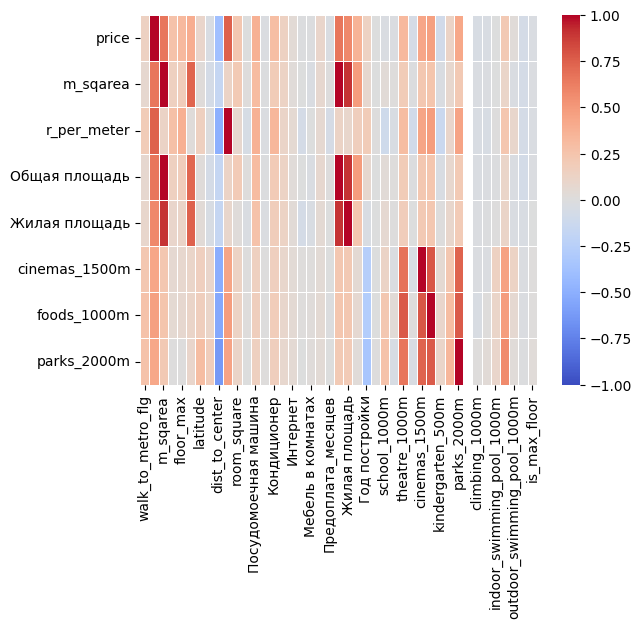

dist_to_center         -0.389894
malls_2000m             0.211420
room_square             0.232145
floor_flat              0.262465
Кондиционер             0.289424
theatre_1000m           0.320972
floor_max               0.324909
Площадь кухни           0.367091
Посудомоечная машина    0.368993
rooms                   0.393396
parks_2000m             0.425976
cinemas_1500m           0.433743
foods_1000m             0.462515
Жилая площадь           0.579288
Общая площадь           0.658127
m_sqarea                0.661579
r_per_meter             0.743600
price                   1.000000
Name: price, dtype: float64

In [90]:
print('Построим матрицу корреляции для числовых признаков к price')
import seaborn as sns
import matplotlib.pyplot as plt
 #

sns.heatmap(df.corr()[df.corr()['price'].abs()>0.4], #только для взаимосвязи >0.4
            vmin=-1, vmax=+1,  
            cmap="coolwarm",
            linewidths=0.5,
            linecolor='white')

plt.show()
df.corr()[df.corr()['price'].abs()>0.2].sort_values('price')['price'] 

Построим матрицу корреляции для числовых признаков к r_per_meter
На мой взгляд предпочтительнее использовать r_per_meter, так как исключается вариация цены за счет площади
Наиболее значимым признаком является удаленности от центра


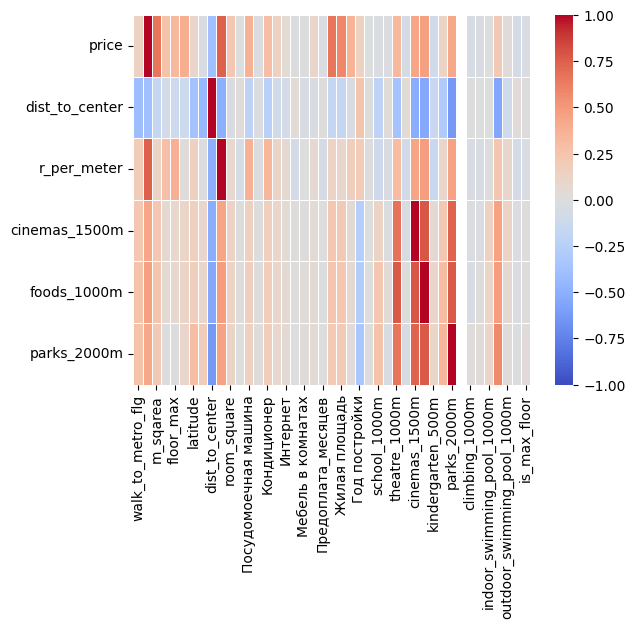

dist_to_center         -0.497119
malls_2000m             0.235832
floor_flat              0.279897
theatre_1000m           0.300007
Кондиционер             0.337127
Посудомоечная машина    0.370608
floor_max               0.379173
cinemas_1500m           0.439301
parks_2000m             0.447147
foods_1000m             0.478617
price                   0.743600
r_per_meter             1.000000
Name: r_per_meter, dtype: float64

In [93]:
print('Построим матрицу корреляции для числовых признаков к r_per_meter')
print('На мой взгляд предпочтительнее использовать r_per_meter, так как исключается вариация цены за счет площади')
print('Наиболее значимым признаком является удаленности от центра')
import seaborn as sns
import matplotlib.pyplot as plt
 #

sns.heatmap(df.corr()[df.corr()['r_per_meter'].abs()>0.4], #только для взаимосвязи >0.4
            vmin=-1, vmax=+1,  
            cmap="coolwarm",
            linewidths=0.5,
            linecolor='white')

plt.show()
df.corr()[df.corr()['r_per_meter'].abs()>0.2].sort_values('r_per_meter')['r_per_meter'] 

### Поиск дополнительных очагов, кроме центра

In [134]:
#сложность с округлением lat в том, что при просто круглении до сотых получаются прямоугольники
dfm = pd.read_sql('''
with cte as (
select
   (floor(latitude*100) +
   case when latitude*100 - floor(latitude*100) <0.25 then 0
   when latitude*100 - floor(latitude*100) <=0.75 then 0.5
   when latitude*100 - floor(latitude*100) >0.75 then 1 end)/100 grid_lat,
   round(longitude::numeric,2) grid_lon,
   avg(r_per_meter) r_per_meter,
   avg(dist_to_center) dist_to_center
from
	team18.dataset_table
group by 
   (floor(latitude*100) +
   case when latitude*100 - floor(latitude*100) <0.25 then 0
   when latitude*100 - floor(latitude*100) <=0.75 then 0.5
   when latitude*100 - floor(latitude*100) >0.75 then 1 end)/100,
   round(longitude::numeric,2))
   
select 
'[['||
'['||text(round(   (grid_lat::numeric-0.0025)::numeric    ,3)) ||', ' || text(round(   (grid_lon::numeric-0.005)::numeric    ,3))||'], '
'['||text(round(   (grid_lat::numeric+0.0025)::numeric    ,3)) ||', ' || text(round(   (grid_lon::numeric-0.005)::numeric    ,3))||'], '
'['||text(round(   (grid_lat::numeric+0.0025)::numeric    ,3)) ||', ' || text(round(   (grid_lon::numeric+0.005)::numeric    ,3))||'], '
'['||text(round(   (grid_lat::numeric-0.0025)::numeric    ,3)) ||', ' || text(round(   (grid_lon::numeric+0.005)::numeric    ,3))||']'
||']]' as square,
grid_lat,
grid_lon,
r_per_meter,
dist_to_center,
ntile(15) over(order by r_per_meter) color_map
from cte
    ''',con=mcfg.pg2())

color_palette = {
 15: "#FF0000", # Красный
 14: "#FF2400",
 13: "#FF4700",
 12: "#FF6B00",
 11: "#FF8E00",
 10: "#FFB200",
 9: "#FFD500",
 8: "#FFFF00", # Чистый желтый
 7: "#FFFF24",
 6: "#FFFF47",
 5: "#FFFF6B",
 4: "#FFFF8E",
 3: "#FFFFB2",
 2: "#FFFFD5",
 1: "#FFFFE0" # Светло-желтый
}
dfm['col'] = dfm['color_map'].replace(color_palette)

In [139]:
import folium

mapObj = folium.Map(location=[55.757, 37.604], zoom_start=11)
for index,row in dfm.iterrows():
    folium.Polygon(
        eval(row['square']),
        color='black',  # цвет границы
        weight=0.3,      # толщина линии
        fill=True,     # заливка
        fill_color=row['col'],  # цвет заливки
        fill_opacity=0.4  # прозрачность заливки
    ).add_to(mapObj)
print('Видим, что общий паттерн один - при удалении от центра стоимость за квадратный метр падает')
mapObj

In [143]:
print('Видим в самом центре светлые пятна - изучим их природу')
print('Топ2 результата - станции метро не из центра')
print('Аномалия вызвана тем, что адресс распознается некорректно')
print('''Ввиду сильной взаимосвязи стоимости и удаленности от центра следует задать примерное значение удаленности от центра
или исключить их из выборки''')
df[df['dist_to_center']<=0].sort_values('price').head(5)

Видим в самом центре светлые пятна - изучим их природу
Топ2 результата - станции метро не из центра
Аномалия вызвана тем, что адресс распознается некорректно
Ввиду сильной взаимосвязи стоимости и удаленности от центра следует задать примерное значение удаленности от центра
или исключить их из выборки


,metro,walk_to_metro_flg,address,price,m_sqarea,floor_flat,floor_max,rooms,latitude,longitude,district_name,dist_to_center,r_per_meter,room_square,Холодильник,Посудомоечная машина,Стиральная машина,Кондиционер,Телевизор,Интернет,Мебель на кухне,Мебель в комнатах,Оплата ЖКХ,Залог,Предоплата_месяцев,Срок аренды,С животными,С детьми,Общая площадь,Жилая площадь,Площадь кухни,Санузел,Балкон/лоджия,Вид из окон,Ремонт,Год постройки,Количество лифтов,Тип перекрытий,Парковка,Отопление,Аварийность,school_1000m,shops_200m,theatre_1000m,fitness_500m,cinemas_1500m,foods_1000m,kindergarten_500m,libraries_1000m,parks_2000m,post_office_1000m,climbing_1000m,fields_1000m,indoor_swimming_pool_1000m,malls_2000m,outdoor_swimming_pool_1000m,is_first_floor,is_max_floor
7993,Нижегородская,True,"Москва, ЮВАО, р-н Текстильщики, м. Нижегородск...",48,35.0,6.0,17.0,1,55.755864,37.617698,Центральный,0.0,1371.0,35.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,счетчики отдельно,48000.0,1.0,от года,None,None,35.0,20.0,10.0,1 совмещенный,1 балкон,None,Евроремонт,1966.0,"1 пассажирский, 1 грузовой",Железобетонные,None,Центральное,0.0,5,7,10,0,16,522,0,0,73,0,0,0,0,28,0,False,False
13118,Текстильщики,True,"Москва, ЮВАО, р-н Текстильщики, м. Текстильщик...",50,45.0,5.0,5.0,2,55.755864,37.617698,Центральный,0.0,1111.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,None,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,NaN,5,7,10,0,16,522,0,0,73,0,0,0,0,28,0,False,True
9330,Охотный ряд,True,"Москва, ЦАО, р-н Тверской, м. Охотный ряд, Тве...",115,50.0,4.0,6.0,2,55.761214,37.611158,Центральный,0.0,2300.0,25.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,счетчики отдельно,115000.0,1.0,от года,None,None,50.0,30.0,10.0,1 совмещенный,1 балкон,Во двор,Дизайнерский,1930.0,1 пассажирский,Железобетонные,ПарковкаНаземная,Центральное,0.0,23,1,22,2,15,730,0,1,63,0,0,0,0,26,0,False,False
9320,Охотный ряд,True,"Москва, ЦАО, р-н Пресненский, м. Тверская, пер...",120,31.0,6.0,9.0,1,55.758428,37.605786,Центральный,0.0,3870.0,31.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,включены в сумму,120000.0,1.0,от года,None,None,31.0,16.0,6.0,1 раздельный,1 балкон,Во двор,Евроремонт,1935.0,1 пассажирский,Железобетонные,None,Центральное,0.0,22,2,24,0,13,597,1,2,68,0,0,0,0,29,0,False,False
9327,Охотный ряд,True,"Москва, ЦАО, р-н Тверской, м. Охотный ряд, Тве...",120,66.0,4.0,12.0,2,55.760256,37.611446,Центральный,0.0,1818.0,33.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,счетчики отдельно,110000.0,1.0,от года,None,None,66.0,35.0,14.0,1 совмещенный,2 балкона,None,Евроремонт,1940.0,"1 пассажирский, 1 грузовой",Нет информации,None,Центральное,0.0,20,1,23,2,16,726,0,1,61,0,0,0,0,25,0,False,False


### Смотрим распределение значений по стоимости квартир за месяц

Видим длинный хвост - следует избавиться от выбросов


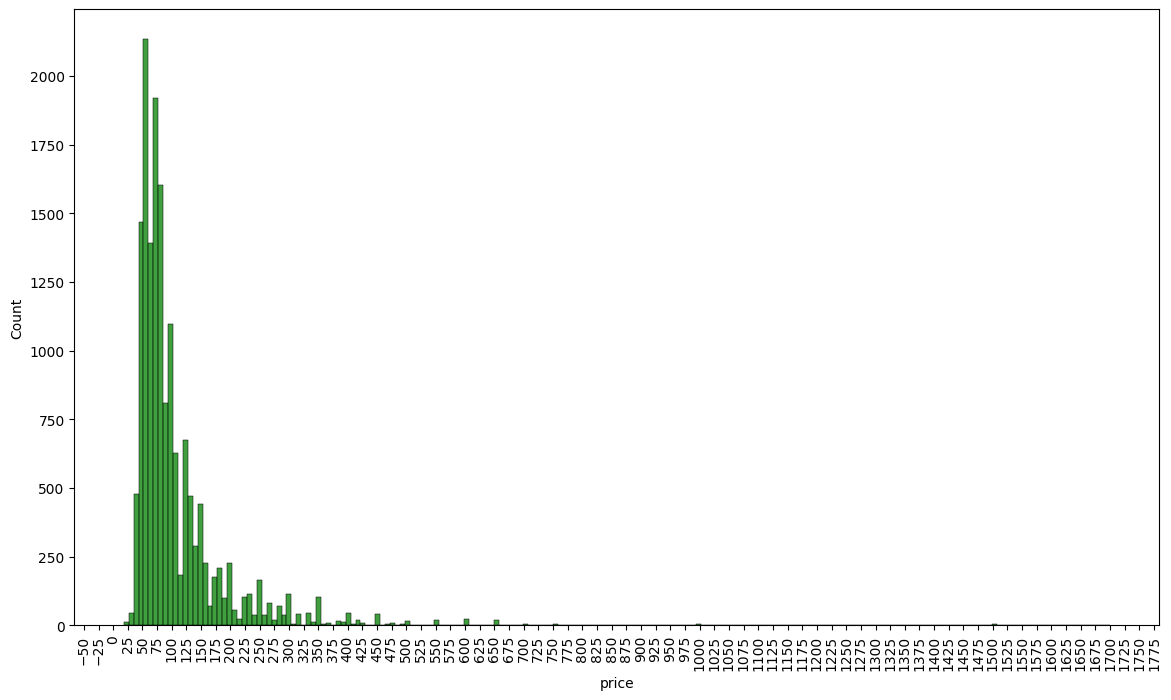

In [122]:
print('Видим длинный хвост - следует избавиться от выбросов')
fig, ax = plt.subplots(figsize=(14, 8))
sns.histplot(
    data=df,        # отсекаем выбросы для понимания масштаба
    x="price",   # переменная для визуализации
    bins=200,          # количество интервалов
    color='green',   # цвет гистограммы
    ax=ax
)
ax.locator_params(axis='x', nbins=90)
plt.xticks(rotation=90)
plt.show()

In [145]:
def borders(data):
    iqr = data['price'].quantile([0.75]).values[0] - data['price'].quantile([0.25]).values[0] # находим iqr общий 
    bottom_border = data['price'].quantile([0.25]).values[0] - iqr*1.5
    top_border    = data['price'].quantile([0.75]).values[0] + iqr*1.5
    return bottom_border,top_border
    
bottom_border,top_border = borders(df)
print(f"""При полуторном интерквартильном размахе ({bottom_border} - {top_border}) по всем данным мы отсекаем 
{len(df[df['price']>=top_border])} из {len(df)}
""")

print("Уточним понятие выбросы с учетом округа (так как в мск значения выше)")

reg_borders = {}
for region in df['district_name'].unique():
    df_reg = df[df['district_name']==region]
    reg_borders[region] = borders(df_reg)


df['reg_borders'] = df['district_name'].map(reg_borders)
df['in_borders'] = (df['price'] >= df['reg_borders'].map(lambda x: x[0])) & (df['price'] <= df['reg_borders'].map(lambda x: x[1]))

print(f"""
Таким образом выбросами у нас в данных являются только {len(df[~df['in_borders']])} значений 
""")
reg_borders

При полуторном интерквартильном размахе (-30.0 - 210.0) по всем данным мы отсекаем 
1385 из 16060

Уточним понятие выбросы с учетом округа (так как в мск значения выше)

Таким образом выбросами у нас в данных являются только 877 значений 



{'Восточный': (17.5, 117.5),
 'Троицкий': (19.0, 75.0),
 'Юго-Восточный': (15.0, 135.0),
 'Южный': (-15.0, 185.0),
 'Юго-Западный': (0.0, 160.0),
 'Северо-Восточный': (0.0, 160.0),
 'Западный': (-42.5, 257.5),
 'Центральный': (-188.0, 580.0),
 'Северный': (-37.25, 248.75),
 'Новомосковский': (12.5, 112.5),
 'Северо-Западный': (-32.5, 227.5),
 'Зеленоградский': (10.0, 90.0),
 None: (nan, nan)}

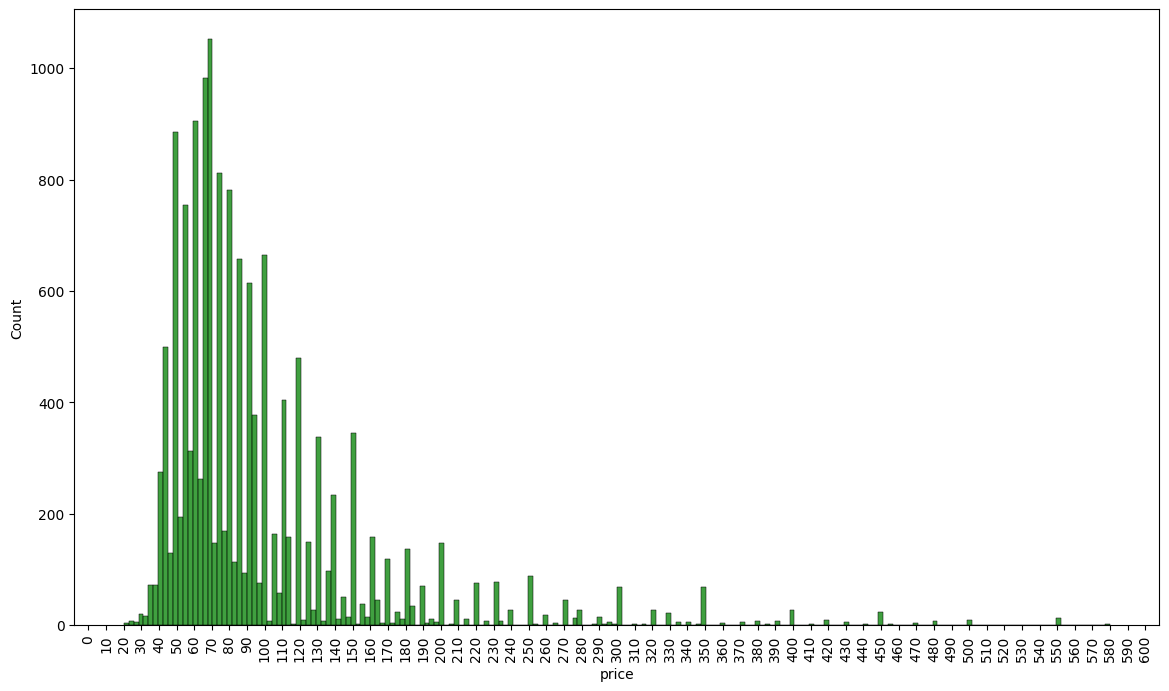

In [146]:
#визуализируем после очистки от выбросов по районам
fig, ax = plt.subplots(figsize=(14, 8))
sns.histplot(
    data=df[df['in_borders']],       
    x="price",   # переменная для визуализации
    bins=200,          # количество интервалов
    color='green',   # цвет гистограммы
    ax=ax
)
ax.locator_params(axis='x', nbins=100)
plt.xticks(rotation=90)
plt.show()

### Смотрим распределение значений по стоимости квартир за месяц по районом

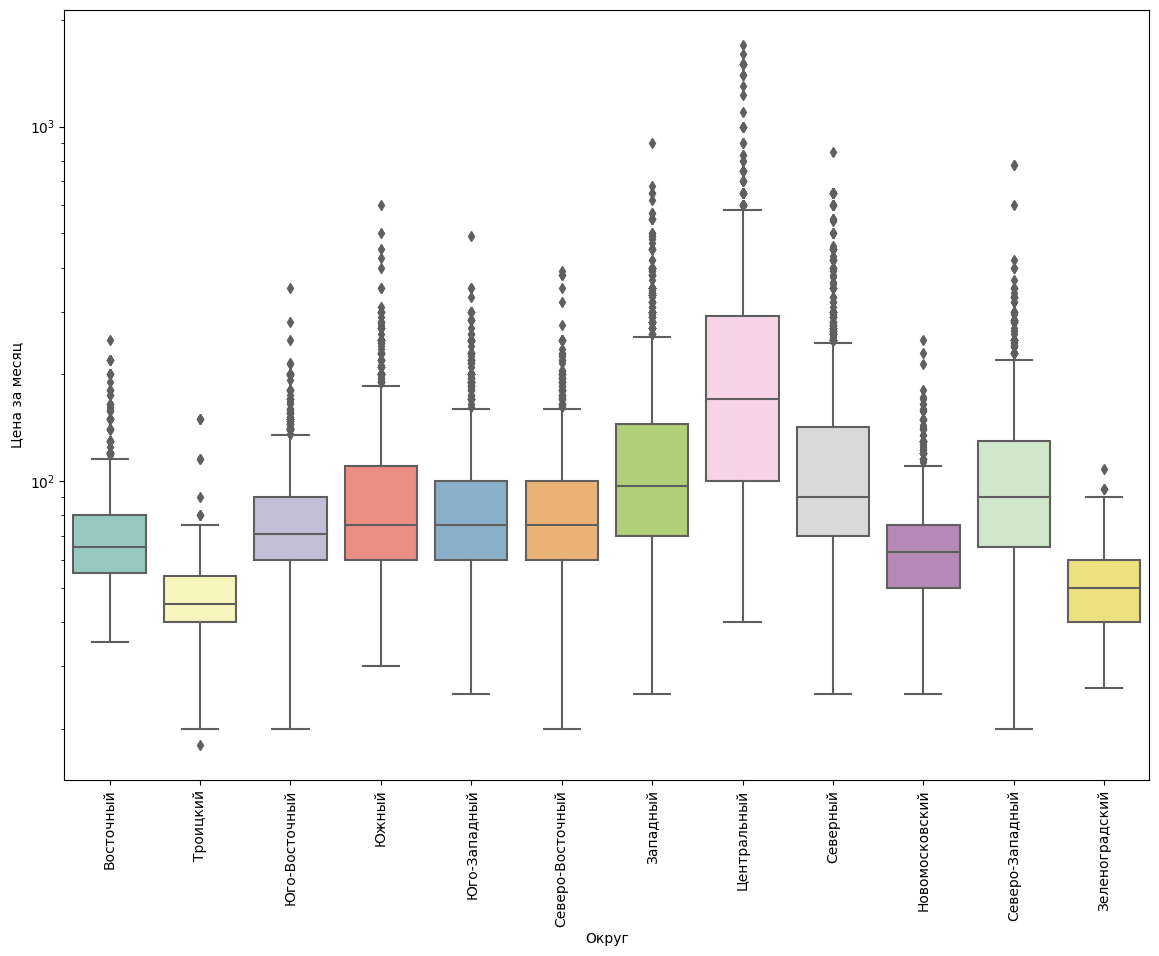

In [147]:
#подтверждаем, что по Москве в среднем, по медиане данные выше
plt.figure(figsize=(14, 10))
sns.boxplot(
    x="district_name",  # категориальная переменная
    y="price",  # числовая переменная
    data=df,
    palette="Set3"
)
plt.xticks(rotation=90)
plt.yscale('log')
plt.xlabel("Округ")
plt.ylabel("Цена за месяц")
plt.show()

### Смотрим на распределение значений по цене на м2

Видим похожий хвост, попробуем убрать выбросы


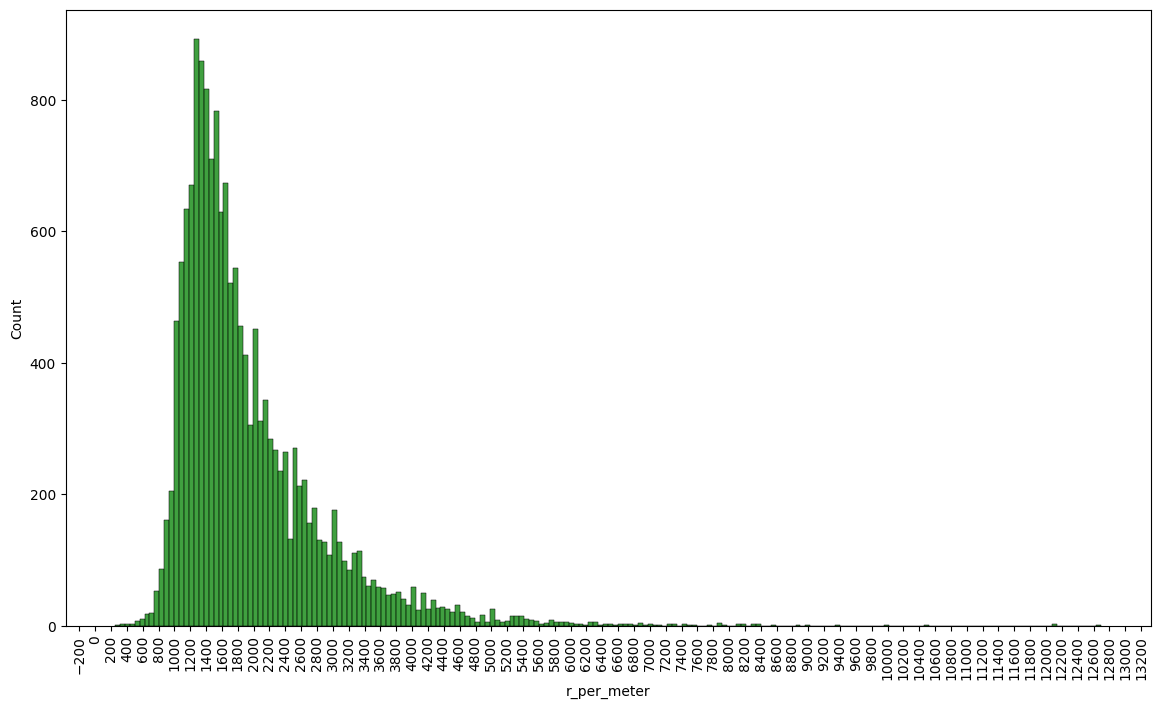

In [151]:
print('Видим похожий хвост, попробуем убрать выбросы')
fig, ax = plt.subplots(figsize=(14, 8))
sns.histplot(
    data=df,        # отсекаем выбросы для понимания масштаба
    x="r_per_meter",   # переменная для визуализации
    bins=200,          # количество интервалов
    color='green',   # цвет гистограммы
    ax=ax
)
ax.locator_params(axis='x', nbins=90)
plt.xticks(rotation=90)
plt.show()

In [154]:
def borders(data):
    iqr = data['r_per_meter'].quantile([0.75]).values[0] - data['r_per_meter'].quantile([0.25]).values[0] # находим iqr общий 
    bottom_border = data['r_per_meter'].quantile([0.25]).values[0] - iqr*1.5
    top_border    = data['r_per_meter'].quantile([0.75]).values[0] + iqr*1.5
    return bottom_border,top_border
    
bottom_border,top_border = borders(df)
print(f"""При полуторном интерквартильном размахе ({bottom_border} - {top_border}) по всем данным мы отсекаем 
{len(df[df['r_per_meter']>=top_border])} из {len(df)}
""")

print("Уточним понятие выбросы с учетом округа (так как в мск значения выше)")

reg_borders = {}
for region in df['district_name'].unique():
    df_reg = df[df['district_name']==region]
    reg_borders[region] = borders(df_reg)


df['reg_borders'] = df['district_name'].map(reg_borders)
df['in_borders'] = (df['r_per_meter'] >= df['reg_borders'].map(lambda x: x[0])) & (df['r_per_meter'] <= df['reg_borders'].map(lambda x: x[1]))

print(f"""
Таким образом выбросами у нас в данных являются только {len(df[~df['in_borders']])} значений 
""")
reg_borders

При полуторном интерквартильном размахе (-100.5 - 3695.5) по всем данным мы отсекаем 
832 из 16060

Уточним понятие выбросы с учетом округа (так как в мск значения выше)

Таким образом выбросами у нас в данных являются только 555 значений 



{'Восточный': (467.5, 2519.5),
 'Троицкий': (505.0, 1601.0),
 'Юго-Восточный': (200.0, 3000.0),
 'Южный': (-28.25, 3483.75),
 'Юго-Западный': (453.25, 2675.25),
 'Северо-Восточный': (163.0, 3235.0),
 'Западный': (85.5, 3833.5),
 'Центральный': (-506.5, 6457.5),
 'Северный': (-225.625, 4263.375),
 'Новомосковский': (468.0, 2208.0),
 'Северо-Западный': (-378.875, 4290.125),
 'Зеленоградский': (452.125, 1795.125),
 None: (nan, nan)}

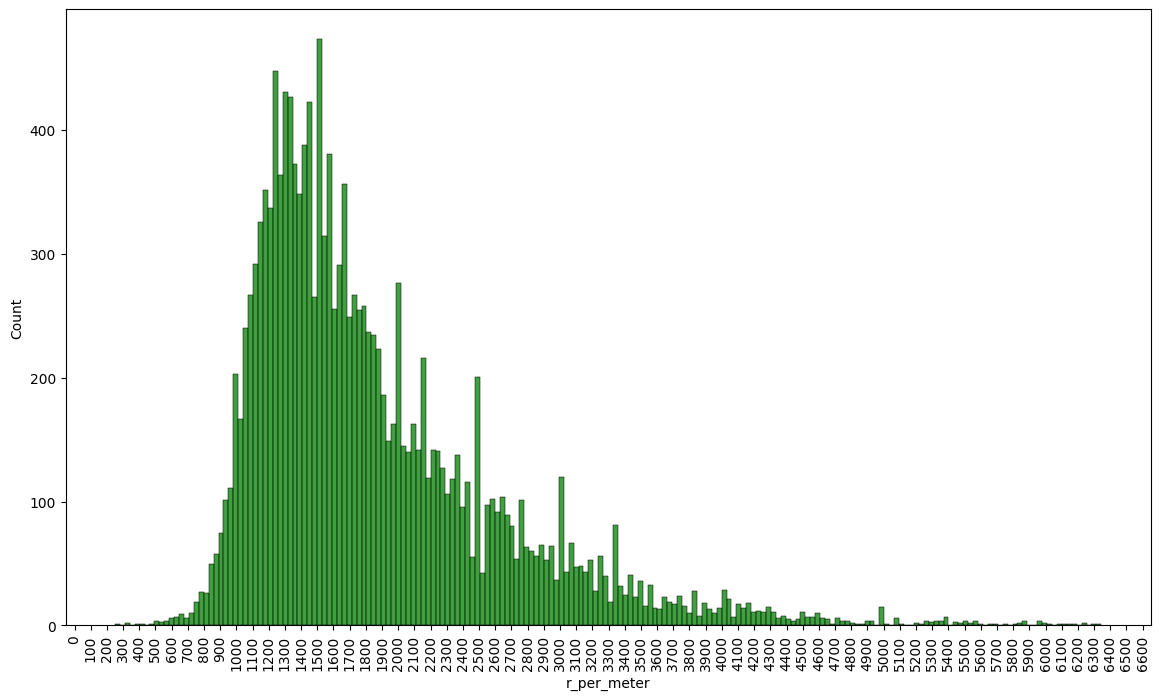

In [156]:
#визуализируем после очистки от выбросов по районам
fig, ax = plt.subplots(figsize=(14, 8))
sns.histplot(
    data=df[df['in_borders']],       
    x="r_per_meter",   # переменная для визуализации
    bins=200,          # количество интервалов
    color='green',   # цвет гистограммы
    ax=ax
)
ax.locator_params(axis='x', nbins=100)
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='r_per_meter', ylabel='m_sqarea'>

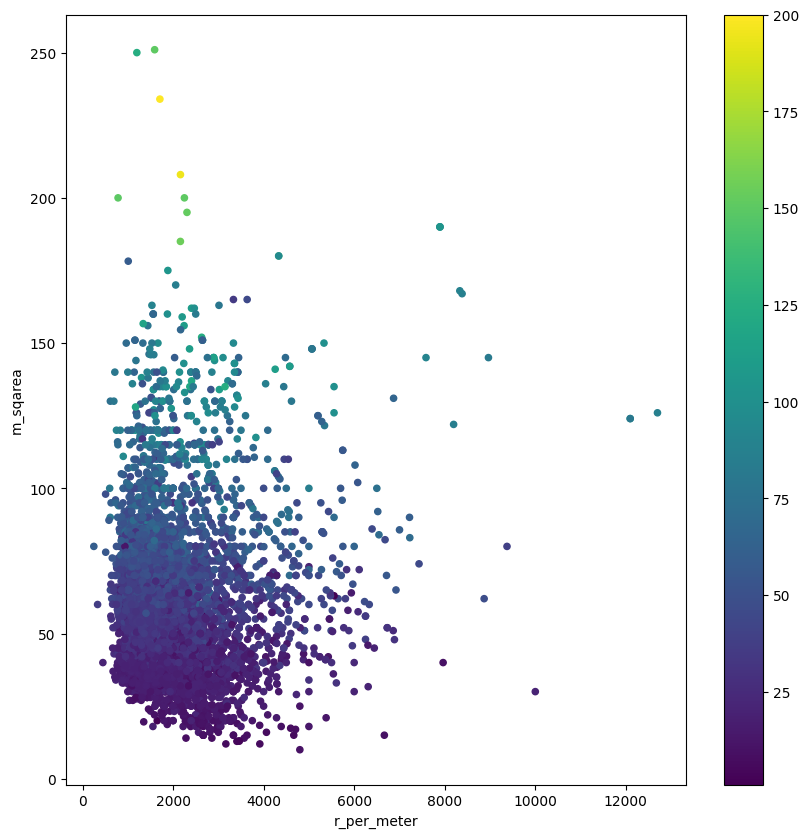

In [201]:
df[['r_per_meter','m_sqarea']].plot(
    kind='scatter',
    x='r_per_meter',
    y='m_sqarea',
    figsize=(10,10),
    c=df['Жилая площадь'], cmap='viridis'
)

<AxesSubplot:xlabel='r_per_meter', ylabel='price'>

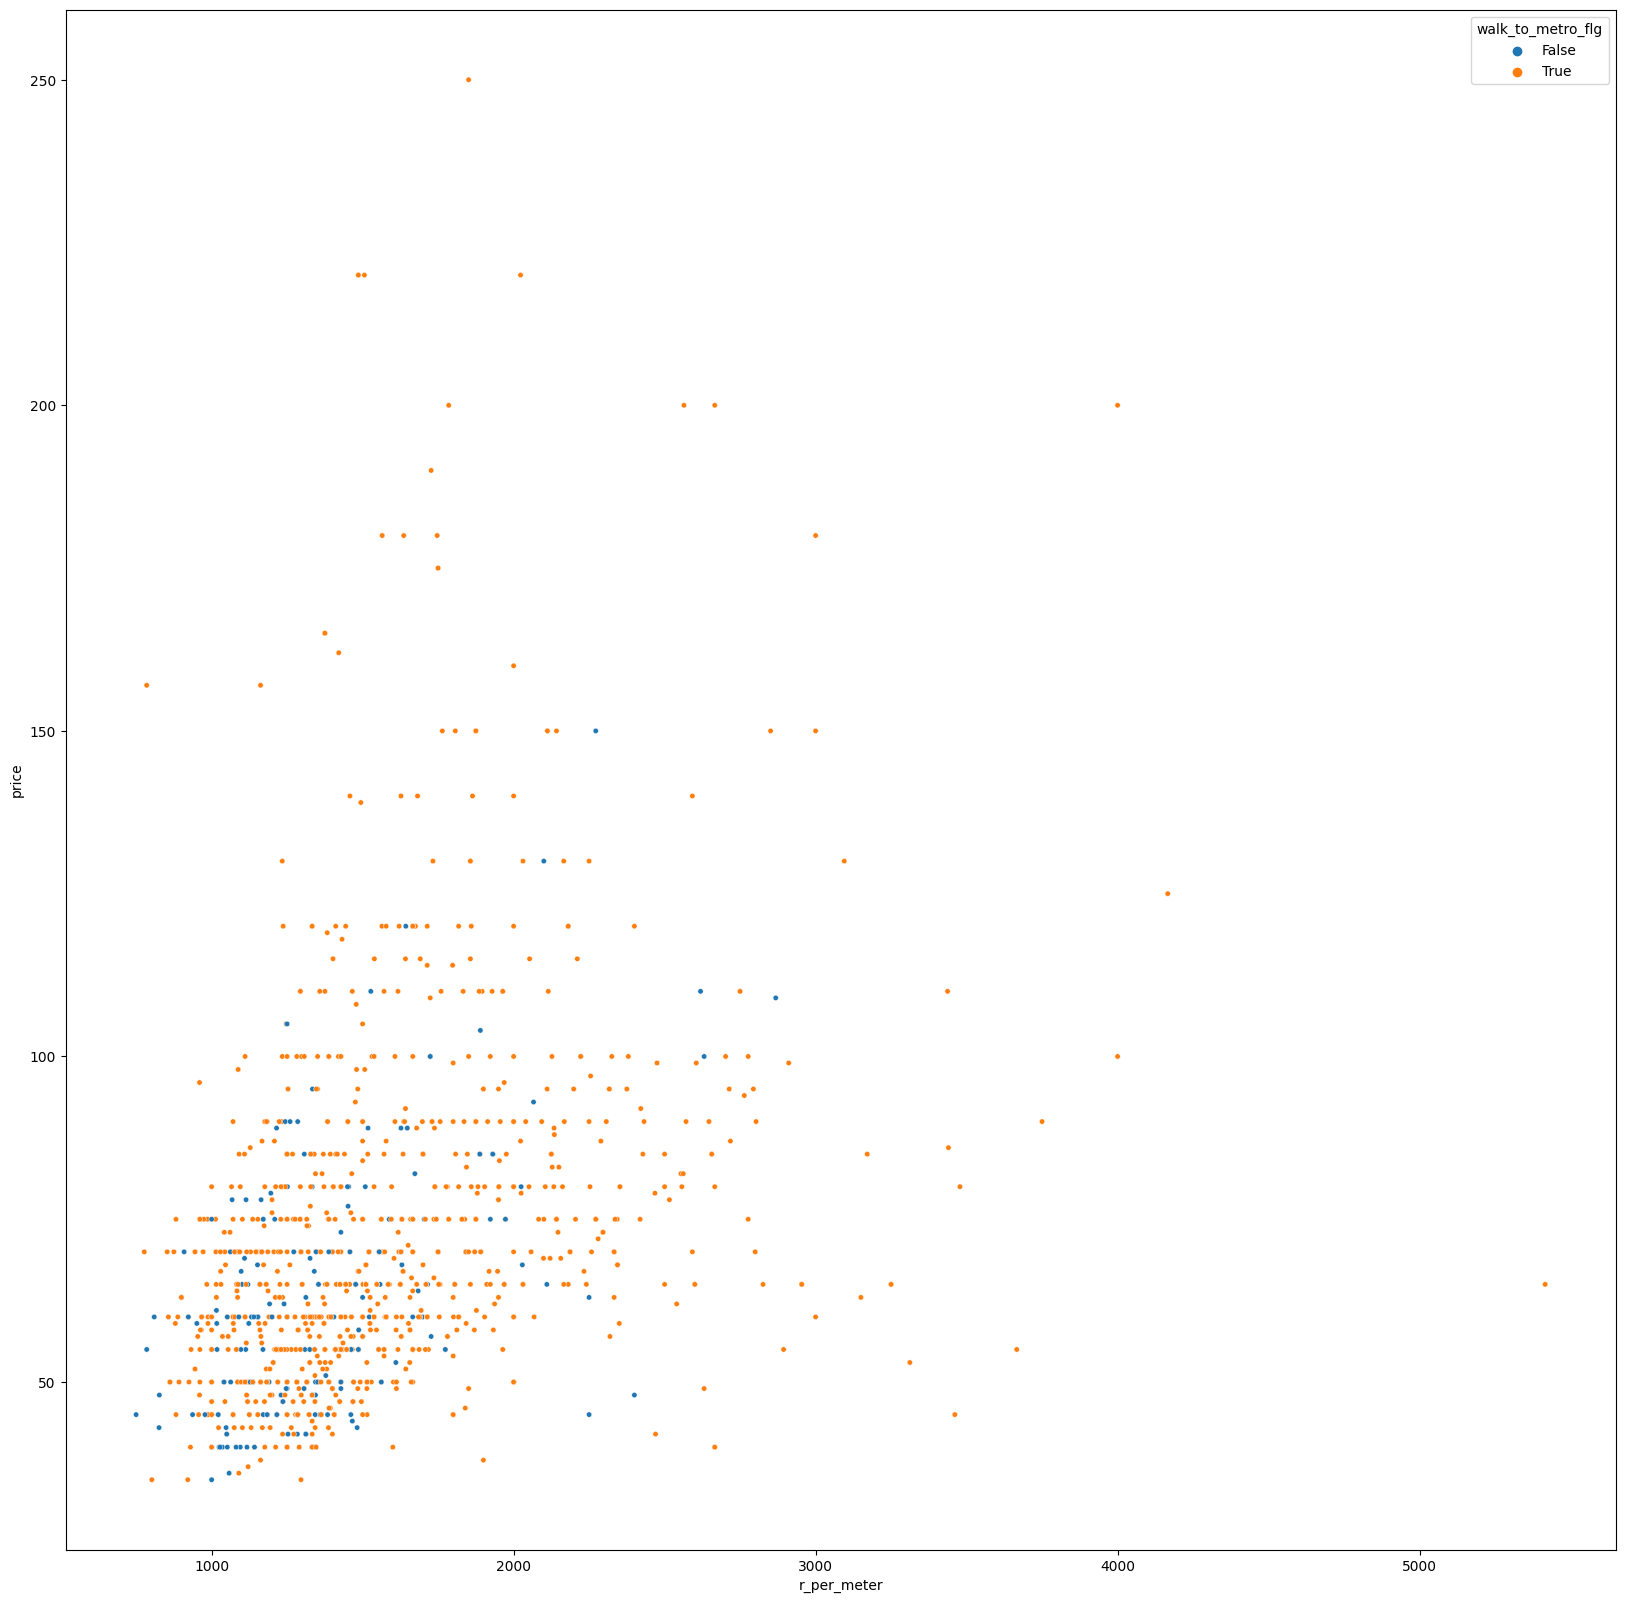

In [53]:
fig, ax = plt.subplots(figsize=(20, 20))
dft = df[(df['district_name']=='Восточный')]
sns.scatterplot(data=dft, x="r_per_meter", y="price", hue="walk_to_metro_flg",s=15,ax=ax,cmap="RdGy")